# Speeding up the solvers

This notebook contains a collection of tips on how to speed up the solvers

In [1]:
%pip install pybamm -q    # install PyBaMM if it is not installed
import pybamm
import matplotlib.pyplot as plt
import numpy as np

You should consider upgrading via the '/Users/vsulzer/Documents/Energy_storage/PyBaMM/.tox/dev/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Choosing a solver

Since it is very easy to switch which solver is used for the model, we recommend you try different solvers for your particular use case. In general, the `CasadiSolver` is the fastest.

Once you have found a good solver, you can further improve performance by trying out different values for the `method`, `rtol`, and `atol` arguments. Further options are sometimes available, but are solver specific. See [solver API docs](https://pybamm.readthedocs.io/en/latest/source/solvers/index.html) for details.

## Choosing and optimizing CasadiSolver settings

### Fast mode vs safe mode

The `CasadiSolver` comes with a `mode` argument which can be set to "fast" or "safe" (the third option, "safe without grid", is experimental and should not be used for now).
The "fast" mode is faster but ignores any "events" (such as a voltage cut-off point), while the "safe" mode is slower but does stop at events (with manually implemented "step-and-check" under the hood). Therefore, "fast" mode should be used whenever events are not expected to be hit (for example, when simulating a drive cycle or a constant-current discharge where the time interval is such that the simulation will finish before reaching the voltage cut-off). Conversely, "safe" mode should be used whenever events are important: in particular, when using the `Experiment` class.

To demonstrate the difference between safe mode and fast mode, consider the following example

In [2]:
# Set up model
model = pybamm.lithium_ion.DFN()
param = model.default_parameter_values
cap = param["Nominal cell capacity [A.h]"]
param["Current function [A]"] = cap * pybamm.InputParameter("Crate")
sim = pybamm.Simulation(model, parameter_values=param)

# Set up solvers. Reduce max_num_steps for the fast solver, for faster errors
fast_solver = pybamm.CasadiSolver(mode="fast", extra_options_setup={"max_num_steps": 1000})
safe_solver = pybamm.CasadiSolver(mode="safe")

Both solvers can solve the model up to 3700 s, but the fast solver ignores the voltage cut-off around 3.1 V

Safe: 392.261 ms
Fast: 131.810 ms


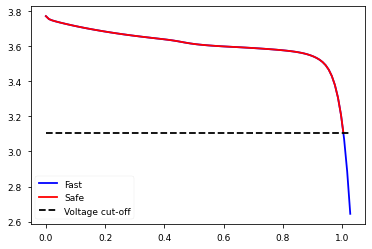

In [3]:
safe_sol = sim.solve([0,3700], solver=safe_solver, inputs={"Crate": 1})
fast_sol = sim.solve([0,3700], solver=fast_solver, inputs={"Crate": 1})

timer = pybamm.Timer()
print("Safe:", safe_sol.solve_time)
print("Fast:", fast_sol.solve_time)

cutoff = param["Lower voltage cut-off [V]"]
plt.plot(fast_sol["Time [h]"].data, fast_sol["Terminal voltage [V]"].data, "b-", label="Fast")
plt.plot(safe_sol["Time [h]"].data, safe_sol["Terminal voltage [V]"].data, "r-", label="Safe")
plt.plot(fast_sol["Time [h]"].data, cutoff * np.ones_like(fast_sol["Time [h]"].data), "k--", label="Voltage cut-off")
plt.legend();

If we increase the integration interval, the safe solver still stops at the same point, but the fast solver fails

Safe: 476.941 ms
Solving fast mode, error occured: .../casadi/interfaces/sundials/idas_interface.cpp:591: IDASolve returned "IDA_CONV_FAIL". Consult IDAS documentation.


At t = 0.179194 and h = 3.39292e-28, the corrector convergence failed repeatedly or with |h| = hmin.


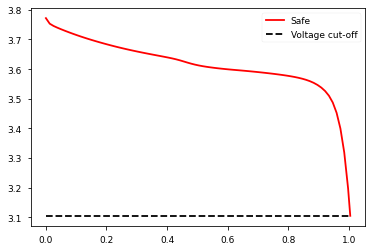

In [4]:
safe_sol = sim.solve([0,4500], solver=safe_solver, inputs={"Crate": 1})

print("Safe:", safe_sol.solve_time)

plt.plot(safe_sol["Time [h]"].data, safe_sol["Terminal voltage [V]"].data, "r-", label="Safe")
plt.plot(safe_sol["Time [h]"].data, cutoff * np.ones_like(safe_sol["Time [h]"].data), "k--", label="Voltage cut-off")
plt.legend();

try:
    sim.solve([0,4500], solver=fast_solver, inputs={"Crate": 1})
except pybamm.SolverError as e:
    print("Solving fast mode, error occured:", e.args[0])

It should be noted here that the time in the warning "At t = 0.179234, , mxstep steps taken before reaching tout" is dimensionless time, since this is the time that the casadi solver sees. This can be converted to dimensional time as follows:

In [5]:
print(f"Errored at {0.179234 * param.evaluate(model.timescale)} seconds")

Errored at 4050.4391486585114 seconds


We can solve with fast mode up to close to this time to understand why the model is failing

In [6]:
fast_sol = sim.solve([0,4049], solver=fast_solver, inputs={"Crate": 1})
fast_sol.plot([
    "Minimum negative particle surface concentration",
    "Electrolyte concentration [mol.m-3]",
    "Maximum positive particle surface concentration",
    "Terminal voltage [V]",
], time_unit="seconds", figsize=(9,9));

interactive(children=(FloatSlider(value=0.0, description='t', max=4049.0, step=40.49), Output()), _dom_classes…

In this case, we can see that the reason the solver is failing is that the concentration at the surface of the particles in the positive electrode hit their maximum (dimensionless) value of 1. Since the exchange current density has a term `sqrt(1-c_s_surf)`, the square root of a negative number is complex, `c_s_surf` going above 1 will cause the solver to fail.

As a final note, there are some cases where the "safe" mode prints some warnings. This is linked to how the solver looks for events (sometimes stepping too far), and can be safely ignored if the solution looks sensible.

At t = 0.00668001, , mxstep steps taken before reaching tout.
At t = 0.00174981, , mxstep steps taken before reaching tout.
At t = 0.00174981, , mxstep steps taken before reaching tout.


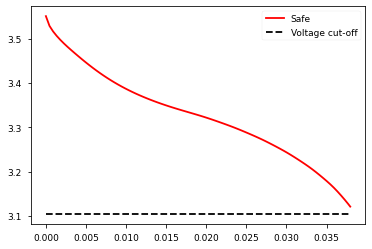

In [7]:
safe_sol_160 = sim.solve([0,160], solver=safe_solver, inputs={"Crate": 10})
plt.plot(safe_sol_160["Time [h]"].data, safe_sol_160["Terminal voltage [V]"].data, "r-", label="Safe")
plt.plot(safe_sol_160["Time [h]"].data, cutoff * np.ones_like(safe_sol_160["Time [h]"].data), "k--", label="Voltage cut-off")
plt.legend();

Reducing the time interval to [0, 150], we see that the solution is exactly the same, without the warnings

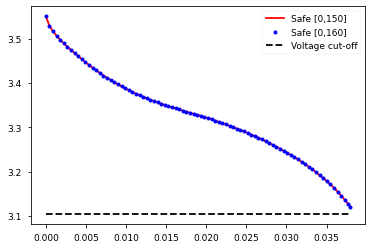

In [8]:
safe_sol_150 = sim.solve([0,150], solver=safe_solver, inputs={"Crate": 10})
plt.plot(safe_sol_150["Time [h]"].data, safe_sol_150["Terminal voltage [V]"].data, "r-", label="Safe [0,150]")
plt.plot(safe_sol_160["Time [h]"].data, safe_sol_160["Terminal voltage [V]"].data, "b.", label="Safe [0,160]")
plt.plot(safe_sol_150["Time [h]"].data, cutoff * np.ones_like(safe_sol_150["Time [h]"].data), "k--", label="Voltage cut-off")
plt.legend();

In [9]:
safe_solver_2 = pybamm.CasadiSolver(mode="safe", dt_max=30)
safe_sol_2 = sim.solve([0,160], solver=safe_solver_2, inputs={"Crate": 10})

### Choosing dt_max to speed up the safe mode

The parameter `dt_max` controls how large the steps taken by the `CasadiSolver` with "safe" mode are when looking for events.

In [10]:
for dt_max in [10,20,100,1000,3700]:
    safe_sol = sim.solve(
        [0,3600], 
        solver=pybamm.CasadiSolver(mode="safe", dt_max=dt_max),
        inputs={"Crate": 1}
    )
    print(f"With dt_max={dt_max}, took {safe_sol.solve_time} "+
          f"(integration time: {safe_sol.integration_time})")

fast_sol = sim.solve([0,3600], solver=fast_solver, inputs={"Crate": 1})
print(f"With 'fast' mode, took {fast_sol.solve_time} "+
      f"(integration time: {fast_sol.integration_time})")

With dt_max=10, took 1.177 s (integration time: 1.064 s)
With dt_max=20, took 1.173 s (integration time: 1.063 s)
With dt_max=100, took 733.209 ms (integration time: 639.751 ms)
With dt_max=1000, took 160.866 ms (integration time: 109.546 ms)
With dt_max=3700, took 137.295 ms (integration time: 84.103 ms)
With 'fast' mode, took 98.616 ms (integration time: 78.933 ms)


In general, a larger value of `dt_max` gives a faster solution, since fewer integrator creations and calls are required.

Below the solution time interval of 36s, the value of `dt_max` does not affect the solve time, since steps must be at least 36s large.
The discrepancy between the solve time and integration time is due to the extra operations recorded by "solve time", such as creating the integrator. The "fast" solver does not need to do this (it reuses the first one it had already created), so the solve time is much closer to the integration time.

The example above was a case where no events are triggered, so the largest `dt_max` works well. If we step over events, then it is possible to makes `dt_max` too large, so that the solver will attempt (and fail) to take large steps past the event, iteratively reducing the step size until it works. For example:

In [11]:
for dt_max in [10,20,100,1000,3600]:
    # Reduce max_num_steps to fail faster
    safe_sol = sim.solve(
        [0,4500], 
        solver=pybamm.CasadiSolver(mode="safe", dt_max=dt_max, extra_options_setup={"max_num_steps": 1000}),
        inputs={"Crate": 1}
    )
    print(f"With dt_max={dt_max}, took {safe_sol.solve_time} "+
          f"(integration time: {safe_sol.integration_time})")

With dt_max=10, took 1.079 s (integration time: 908.498 ms)
With dt_max=20, took 1.012 s (integration time: 840.830 ms)
With dt_max=100, took 628.936 ms (integration time: 508.004 ms)
With dt_max=1000, took 235.521 ms (integration time: 133.730 ms)


At t = 0.0202946 and h = 4.01795e-28, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.0202946 and h = 4.01795e-28, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.0202946 and h = 3.77863e-28, the corrector convergence failed repeatedly or with |h| = hmin.

With dt_max=3600, took 967.320 ms (integration time: 81.977 ms)


The integration time with `dt_max=3600` remains the fastest, but the solve time is the slowest due to all the failed steps.

### Choosing the period for faster experiments

The "period" argument of the experiments also affects how long the simulations take, for a similar reason to `dt_max`. Therefore, this argument can be manually tuned to speed up how long an experiment takes to solve.

We start with one cycle of CCCV

In [12]:
experiment = pybamm.Experiment(
    [
        "Discharge at C/10 for 10 hours or until 3.3 V",
        "Rest for 1 hour",
        "Charge at 1 A until 4.1 V",
        "Hold at 4.1 V until 50 mA",
        "Rest for 1 hour",
    ]
)
solver = pybamm.CasadiSolver(mode="safe", extra_options_setup={"max_num_steps": 1000})
sim = pybamm.Simulation(model, experiment=experiment, solver=solver)
sol = sim.solve()
print("Took ", sol.solve_time)

Took  3.194 s


This gives a nice, smooth voltage curve

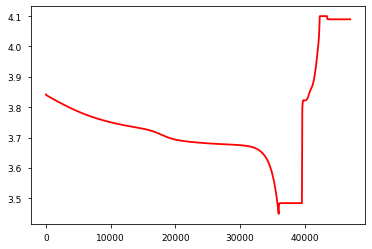

In [13]:
plt.plot(sol["Time [s]"].data, sol["Terminal voltage [V]"].data);

We can speed up the experiment by increasing the period, but tradeoff is that the resolution of the solution becomes worse

Took  1.314 s


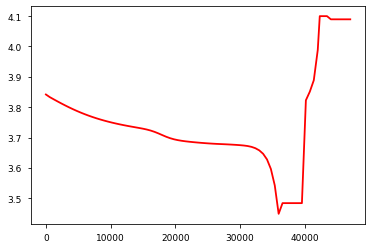

In [14]:
experiment = pybamm.Experiment(
    [
        "Discharge at C/10 for 10 hours or until 3.3 V",
        "Rest for 1 hour",
        "Charge at 1 A until 4.1 V",
        "Hold at 4.1 V until 50 mA",
        "Rest for 1 hour",
    ],
    period="10 minutes",
)
sim = pybamm.Simulation(model, experiment=experiment, solver=solver)
sol = sim.solve()
print("Took ", sol.solve_time)
plt.plot(sol["Time [s]"].data, sol["Terminal voltage [V]"].data);

If we increase the period too much, the experiment becomes slower as the solver takes more failing steps

At t = 0.0556187 and h = 1.41541e-28, the corrector convergence failed repeatedly or with |h| = hmin.


Took  1.145 s


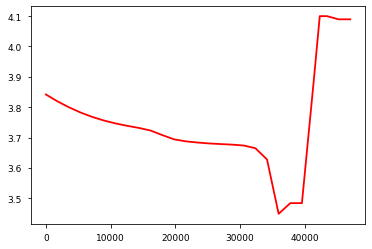

In [15]:
experiment = pybamm.Experiment(
    [
        "Discharge at C/10 for 10 hours or until 3.3 V",
        "Rest for 1 hour",
        "Charge at 1 A until 4.1 V",
        "Hold at 4.1 V until 50 mA",
        "Rest for 1 hour",
    ],
    period="30 minutes",
)
sim = pybamm.Simulation(model, experiment=experiment, solver=solver)
sol = sim.solve()
print("Took ", sol.solve_time)
plt.plot(sol["Time [s]"].data, sol["Terminal voltage [V]"].data);

We can control the period of individual parts of the experiment to get the fastest solution (again, at the cost of resolution)

Took  628.190 ms


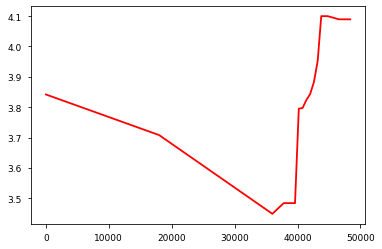

In [16]:
experiment = pybamm.Experiment(
    [
        "Discharge at C/10 for 10 hours or until 3.3 V (5 hour period)",
        "Rest for 1 hour (30 minute period)",
        "Charge at 1 C until 4.1 V (10 minute period)",
        "Hold at 4.1 V until 50 mA (10 minute period)",
        "Rest for 1 hour (30 minute period)",
    ],
)
solver = pybamm.CasadiSolver(mode="safe", extra_options_setup={"max_num_steps": 1000})
sim = pybamm.Simulation(model, experiment=experiment, solver=solver)
sol = sim.solve()
print("Took ", sol.solve_time)
plt.plot(sol["Time [s]"].data, sol["Terminal voltage [V]"].data);

As you can see, this kind of optimization requires a lot of manual tuning. We are working on ways to make the experiment class more efficient in general.

### Changing the time interval

Finally, in some cases, changing the time interval (either the step size or the final time) may affect whether or not the casadi solver can solve the system. 
Therefore, if the casadi solver is failing, it may be worth changing the time interval (usually, reducing step size or final time) to see if that allows the solver to solve the model.
Unfortunately, we have not yet been able to isolate a minimum working example to demonstrate this effect.

## Handling instabilities

If the solver is taking a lot of steps, possibly failing with a `max_steps` error, and the error persists with different solvers and options, this suggests a problem with the model itself. This can be due to a few things:

- A singularity in the model (such as division by zero). Solve up to the time where the model fails, and plot some variables to see if they are going to infinity. You can then narrow down the source of the problem.
- High model stiffness. The first thing to do to tackle this is to non-dimensionalize your model. If you really don't want to do this, or you do it and the problem persists, plot different variables to identify which variables or parameters may be causing problems. To reduce stiffness, all (dimensionless) parameter values should be as close to 1 as possible.
- Non-differentiable functions (see [below](#Smooth-approximations-to-non-differentiable-functions))

If none of these fixes work, we are interested in finding out why - please get in touch!

### Smooth approximations to non-differentiable functions

Some functions, such as `minimum`, `maximum`, `heaviside`, and `abs`, are discontinuous and/or non-differentiable (their derivative is discontinuous). Adaptive solvers can deal with this discontinuity, but will take many more steps close to the discontinuity in order to resolve it. Therefore, using smooth approximations instead can reduce the number of steps taken by the solver, and hence the integration time. See [this post](https://discourse.julialang.org/t/handling-instability-when-solving-ode-problems/9019/5) for more details.

Here is an example using the `maximum` function. The function `maximum(x,1)` is continuous but non-differentiable at `x=1`, where its derivative jumps from 0 to 1. However, we can approximate it using the [`softplus` function](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)#Softplus), which is smooth everywhere and is sometimes used in neural networks as a smooth approximation to the RELU activation function. The `softplus` function is given by
$$
s(x,y;k) = \frac{\log(\exp(kx)+\exp(ky))}{k},
$$
where `k` is a strictly positive smoothing (or sharpness) parameter. The larger the value of `k`, the better the approximation but the stiffer the term (exp blows up quickly!). Usually, a value of `k=10` is a good middle ground.

In PyBaMM, you can either call the `softplus` function directly, or change `pybamm.settings.max_smoothing` to automatically replace all your calls to `pybamm.maximum` with `softplus`.

In [17]:
x = pybamm.Variable("x")
y = pybamm.Variable("y")

# Normal maximum
print("Exact maximum:", pybamm.maximum(x,y))

# Softplus
print("Softplus (k=10):", pybamm.softplus(x,y,10))

# Changing the setting to call softplus automatically
pybamm.settings.max_smoothing = 20
print("Softplus (k=20):", pybamm.maximum(x,y))

# All smoothing parameters can be changed at once
pybamm.settings.set_smoothing_parameters(30)
print("Softplus (k=30):", pybamm.maximum(x,y))

# Change back
pybamm.settings.set_smoothing_parameters("exact")
print("Exact maximum:", pybamm.maximum(x,y))

Exact maximum: maximum(x, y)
Softplus (k=10): log(exp(10.0 * x) + exp(10.0 * y)) / 10.0
Softplus (k=20): log(exp(20.0 * x) + exp(20.0 * y)) / 20.0
Softplus (k=30): log(exp(30.0 * x) + exp(30.0 * y)) / 30.0
Exact maximum: maximum(x, y)


Note that if both sides are constant then pybamm will use the exact value even if the setting is set to smoothing

In [18]:
a = pybamm.InputParameter("a")
pybamm.settings.max_smoothing = 20
# Both inputs are constant so uses exact maximum
print("Exact:", pybamm.maximum(0.999,1).evaluate())
# One input is not constant (InputParameter) so uses softplus
print("Softplus:", pybamm.maximum(a,1).evaluate(inputs={"a": 0.999}))
pybamm.settings.set_smoothing_parameters("exact")

Exact: 1.0
Softplus: 1.0341598589863317


Here is the plot of softplus with different values of `k`

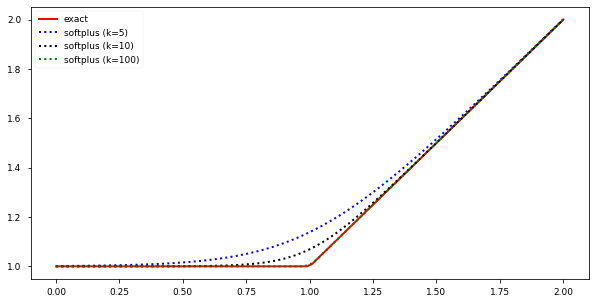

In [19]:
pts = pybamm.linspace(0, 2, 100)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(pts.evaluate(), pybamm.maximum(pts,1).evaluate(), lw=2, label="exact")
ax.plot(pts.evaluate(), pybamm.softplus(pts,1,5).evaluate(), ":", lw=2, label="softplus (k=5)")
ax.plot(pts.evaluate(), pybamm.softplus(pts,1,10).evaluate(), ":", lw=2, label="softplus (k=10)")
ax.plot(pts.evaluate(), pybamm.softplus(pts,1,100).evaluate(), ":", lw=2, label="softplus (k=100)")
ax.legend()

Solving a model with the exact maximum, and smooth approximations, demonstrates a clear speed-up even for a very simple model

In [20]:
model_exact = pybamm.BaseModel()
model_exact.rhs = {x: pybamm.maximum(x, 1)}
model_exact.initial_conditions = {x: 0.5}
model_exact.variables = {"x": x, "max(x,1)": pybamm.maximum(x, 1)}

model_smooth = pybamm.BaseModel()
k = pybamm.InputParameter("k")
model_smooth.rhs = {x: pybamm.softplus(x, 1, k)}
model_smooth.initial_conditions = {x: 0.5}
model_smooth.variables = {"x": x, "max(x,1)": pybamm.softplus(x, 1, k)}

solver = pybamm.CasadiSolver(mode="fast")

# Exact solution
timer = pybamm.Timer()
time = 0
for _ in range(100):
    exact_sol = solver.solve(model_exact, [0, 2])
    # Report integration time, which is the time spent actually doing the integration
    time += exact_sol.integration_time
print("Exact:", time/100)
sols = [exact_sol]

ks = [5, 10, 100]
for k in ks:
    time = 0
    for _ in range(100):
        sol = solver.solve(model_smooth, [0, 2], inputs={"k": k})
        time += sol.integration_time
    print(f"Smooth, k={k}:", time/100)
    sols.append(sol)

pybamm.dynamic_plot(sols, ["x", "max(x,1)"], labels=["exact"] + [f"smooth (k={k})" for k in ks]);

Exact: 366.813 us
Smooth, k=5: 348.585 us
Smooth, k=10: 279.639 us
Smooth, k=100: 325.853 us


interactive(children=(FloatSlider(value=0.0, description='t', max=2.0, step=0.02), Output()), _dom_classes=('w…

#### Other smooth approximations

Here are the other smooth approximations for the other non-smooth functions:

In [21]:
pybamm.settings.set_smoothing_parameters(10)
print("Smooth minimum (softminus):\t {!s}".format(pybamm.minimum(x,y)))
print("Smooth heaviside (sigmoid):\t {!s}".format(x < y))
print("Smooth absolute value: \t\t {!s}".format(abs(x)))
pybamm.settings.set_smoothing_parameters("exact")

Smooth minimum (softminus):	 log(exp(-10.0 * x) + exp(-10.0 * y)) / -10.0
Smooth heaviside (sigmoid):	 (1.0 + tanh(10.0 * (y - x))) / 2.0
Smooth absolute value: 		 x * (exp(10.0 * x) - exp(-10.0 * x)) / (exp(10.0 * x) + exp(-10.0 * x))


## References

The relevant papers for this notebook are:

In [22]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Marc Doyle, Thomas F. Fuller, and John Newman. Modeling of galvanostatic charge and discharge of the lithium/polymer/insertion cell. Journal of the Electrochemical society, 140(6):1526–1533, 1993. doi:10.1149/1.2221597.
[3] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with NumPy. Nature, 585(7825):357–362, 2020. doi:10.1038/s41586-020-2649-2.
[4] Scott G. Marquis, Valentin Sulzer, Robert Timms, Colin P. Please, and S. Jon Chapman. An asymptotic derivation of a single particle model with electrolyte. Journal of The Electrochemical Society, 166(15):A3693–A3706, 2019. doi:10.1149/